# **Email Classifier**


---
This notebook looks into choosing a machine learning model capable of predicting whether an email is safe or a phishing email, based on the email text, based on accuracy.

---

### Table of Contents


##### 1. [Data Exploration and Cleaning](#scrollTo=JaPEPdckoji_&uniqifier=1)

##### 2. [Data Extraction and Transformation](#scrollTo=Wc8D4l956vOA&uniqifier=1)

##### 3. [Model Selection](#scrollTo=RhKs_KCpAzug&uniqifier=1)

##### 4. [Hyperparameters Tuning](#scrollTo=Q7z4QjlliTcQ&uniqifier=1)

##### 5. [Model Evaluation](#scrollTo=eq1pjSbRkFym&uniqifier=1)

##### 6. [Prediction on User Input](#scrollTo=PSJ_Ugi-6iam&uniqifier=1)




---


The original data came from Kaggle and can be found here: https://www.kaggle.com/datasets/subhajournal/phishingemails

---




In [ ]:
# Import all data analysis and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# Models from scikit-Learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

### Data Exploration and Cleaning



---





In [ ]:
# Snapshot of data
df = pd.read_csv("/content/drive/MyDrive/Phishing_Email.csv")
df.head(3)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email


In [ ]:
# Are there any missing values?
df.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [ ]:
# Delete rows with missing values
df.dropna(inplace=True)
df.isna().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

In [ ]:
# Drop ID column because it is the same as the index
df = df.drop("Unnamed: 0", axis=1)
df.head(3)

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email


In [ ]:
# Check the number of target values
df["Email Type"].value_counts()

Safe Email        11322
Phishing Email     7312
Name: Email Type, dtype: int64

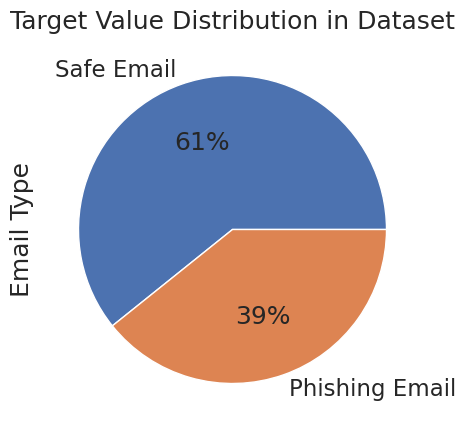

In [ ]:
# Plot target value distribution in dataset

df['Email Type'].value_counts().plot(kind="pie", autopct="%1.0f%%", figsize=(5, 5));
plt.title("Target Value Distribution in Dataset");

### Data Extraction and Transformation




---


In [ ]:
df.loc[df["Email Type"] == "Phishing Email", "Email Type"] = 0
df.loc[df["Email Type"] == "Safe Email", "Email Type"] = 1

In [ ]:
# Data extraction and transformation with TfidVectorizer

feature_extraction = TfidfVectorizer(min_df=1, max_df=0.9, max_features=20000, stop_words="english", lowercase=True)

X = feature_extraction.fit_transform(df["Email Text"]).toarray()
y = df["Email Type"].astype("int")


In [ ]:
# Split data into train and test sets
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Model Selection

---






In [ ]:
 # models
models = {"NB: Gaussian": GaussianNB(),
          "NB: Multinomial": MultinomialNB(),
          "NB: Complement": ComplementNB(),
          "NB: Bernoulli": BernoulliNB()}

# Function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
  # Set random seed
  np.random.seed(42)
  model_scores = {}
  for name, model in models.items():
    # Train models with training data
    model.fit(X_train, y_train)
    # Evaluate the models and appends scores to model_scores dict
    model_scores[name] = model.score(X_test, y_test).round(4)
  return model_scores

# Compare accuracy scores of all models on test data
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             y_train=y_train,
                             X_test=X_test,
                             y_test=y_test)


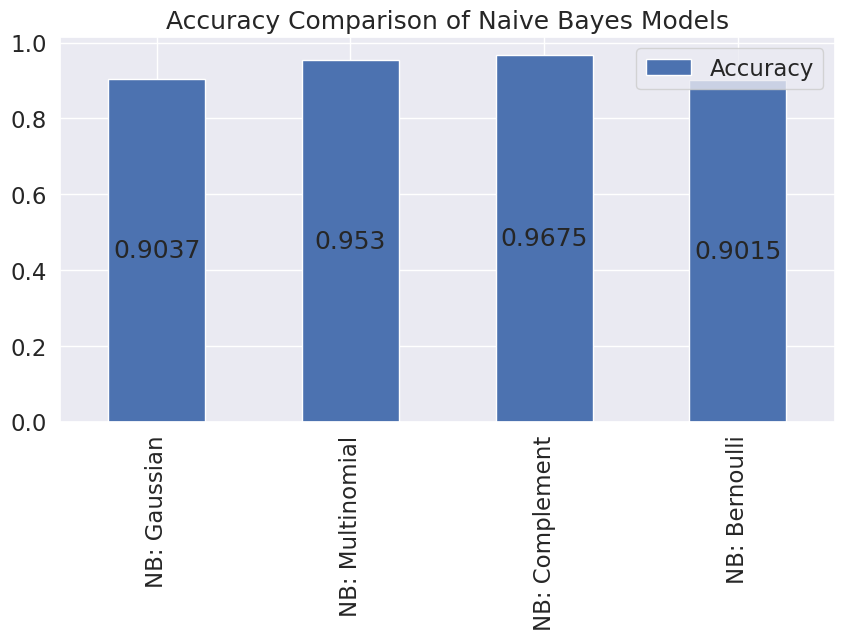

In [ ]:
# Plotting accuracy scores of all models in a bar graph
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
ax = model_compare.T.plot.bar(figsize=(10, 5))
ax.bar_label(ax.containers[0], label_type="center")
plt.title("Accuracy Comparison of Naive Bayes Models");

### Hyperparameters Tuning

---



In [ ]:
# Tuning Complement NB with GridSearchCV
gs_cnb_grid = {"alpha": [0.1, 0.2, 0.3, 0.4],
              "force_alpha": [True, False]}

gs_cnb = GridSearchCV(ComplementNB(),
                     param_grid=gs_cnb_grid,
                     cv=5,
                     verbose=True)

gs_cnb.fit(X_train, y_train)
print(gs_cnb.best_params_)
print(gs_cnb.score(X_test, y_test))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.3, 'force_alpha': True}
0.9686074590823719


### Model Evaluation






---



In [ ]:
# Predictions on test data using tuned model
test_data_preds= gs_cnb.predict(X_test)


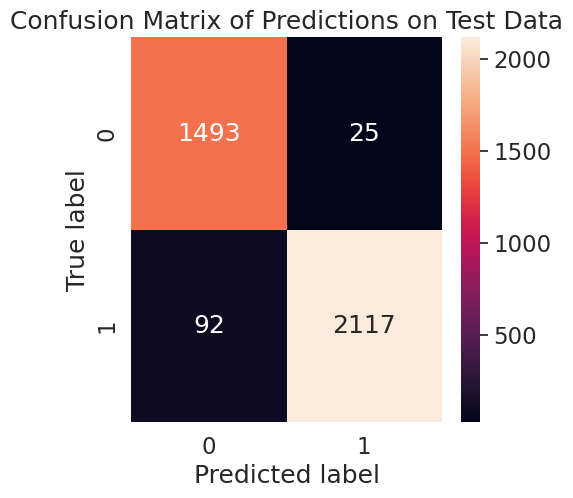

In [ ]:
# Plot confusion matrix of predictions on test data using Seaborn heatmap
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, test_data_preds):

    fig, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(confusion_matrix(y_test, test_data_preds, labels=gs_cnb.classes_),
                     annot=True,
                     cbar=True,
                     fmt="g")

    plt.xlabel("Predicted label") # predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis
    plt.title("Confusion Matrix of Predictions on Test Data")

plot_conf_mat(y_test, test_data_preds)

In [ ]:
# Cross Validation of model after tuning to measure accuracy, precision, recall, and f1

# Classification estimater with arguments finalized after tuning
clf = ComplementNB(alpha=0.3, force_alpha=True)

# Mean accuracy calculated over entire data set with estimator
cv_accuracy = cross_val_score(clf, X, y, cv=5, scoring="accuracy").mean().round(4)

# Mean precision calculated over entire data set with estimator
cv_precision = cross_val_score(clf, X, y, cv=5, scoring="precision").mean().round(4)

# Mean recall calculated over entire data set with estimator
cv_recall = cross_val_score(clf, X, y, cv=5, scoring="recall").mean().round(4)

# Mean F1 score calculated over entire data set with estimator
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring="f1").mean().round(4)



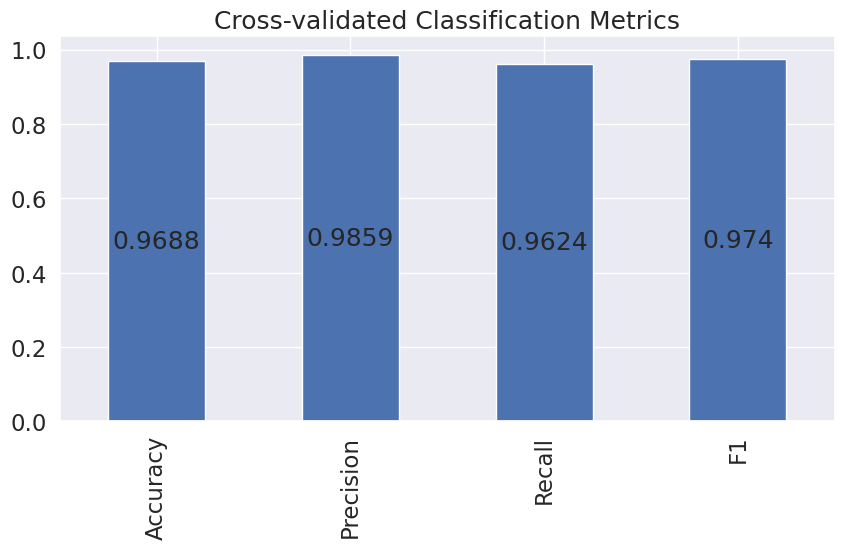

In [ ]:
# Plotting accuracy, precision, recall, and F1 in bar graph
cv_metrics = pd.DataFrame({"Accuracy": cv_accuracy,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                           index=[0])


ax = cv_metrics.T.plot.bar(title="Cross-validated Classification Metrics", legend=False, figsize=(10, 5))
ax.bar_label(ax.containers[0], label_type="center");

### Prediction on User Input


---




In [ ]:
# Save model to pickle file
pickle.dump(gs_cnb, open("gs_complementnb_1.pk1", "wb"))

In [ ]:
# Load model from pickle file
loaded_pickle_model = pickle.load(open("gs_complementnb_1.pk1", "rb"))

In [44]:
# Prediction on user input
input_text = input("Enter email text here: ")
input_text_split = [input_text]

# Text transformation using Tfid Vectorizer
input_text_features = feature_extraction.transform(input_text_split).toarray()

# Predict with model
input_predict = loaded_pickle_model.predict(input_text_features)
if(input_predict[0] == 1):
  print('\033[1m' + 'Safe Email')
else:
  print('\033[1m' + 'Phishing Email')

Enter email text here: Walmart – You’ve been chosen to receive a brand new Fire Tablet! It will take you only a minute and you will receive a fantastic prize. To claim, simply answer a few quick questions regarding your experience with us
Phishing Email
